# Домашнее задание по теме "Компьютерное зрение"

## Дедлайн:
5 декабря, 23:59
Штрафа за просрочку нет, просто все работы, сданные после дедлайна, не будут проверены к последней паре.

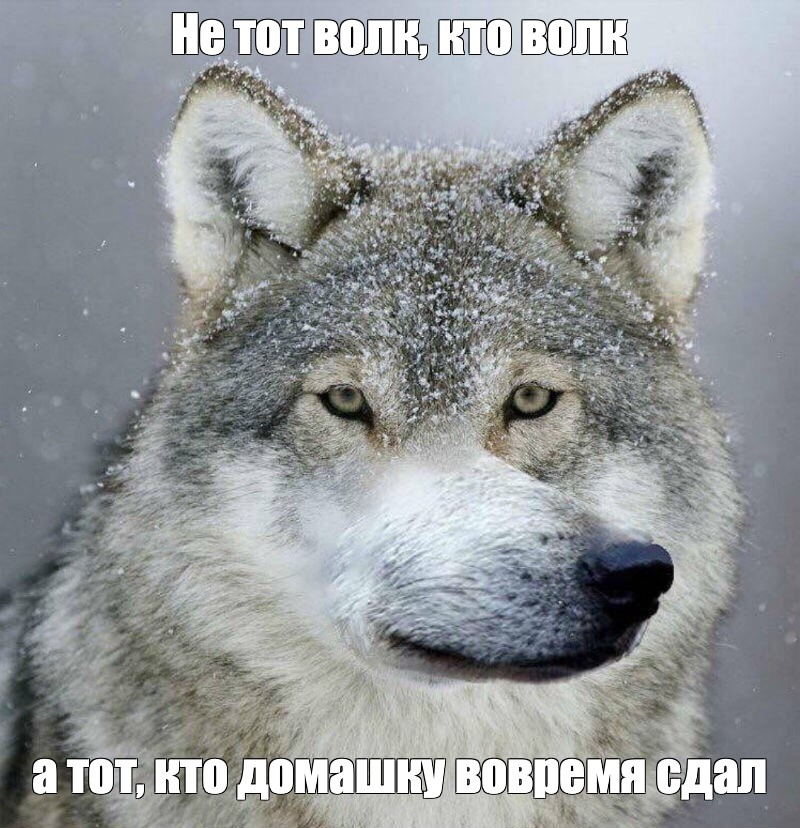

В этом задании мы будем обучать небольшую модель для детекции объектов на основе архитектуры YOLO.
Подробнее об нейросетях YOLO можно прочитать у них в [документации](https://docs.ultralytics.com/models/yolo11/) или на [гитхабе](https://github.com/ultralytics/ultralytics).
Сначала мы разберем весь процесс обучения модели, начиная от сбора данных и заканчивая выбором аугментаций. Вашим домашним заданием будет повторить этот процесс для другого набора данных и других классов.

Далее предполагается, что вы выполняете этот ноутбук с помощью Google Colab (нам потребуются GPU), и загрузили архив, приложенный к этому ноутбуку, к себе на Google Drive.

Смонтируем свой гугл диск к среде, в которой запущен ноутбук

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Распакуем архивы:

In [2]:
!unzip '/content/drive/MyDrive/Colab Notebooks/hw_week7.zip'
!unzip '/content/hw_week7/mammals.zip'
!unzip '/content/hw_week7/wolves_and_dogs.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/hw_week7.zip
   creating: hw_week7/
  inflating: hw_week7/.DS_Store      
  inflating: __MACOSX/hw_week7/._.DS_Store  
  inflating: hw_week7/dog.jpeg       
  inflating: __MACOSX/hw_week7/._dog.jpeg  
  inflating: hw_week7/wolf.jpeg      
  inflating: __MACOSX/hw_week7/._wolf.jpeg  
  inflating: hw_week7/auf.jpg        
  inflating: __MACOSX/hw_week7/._auf.jpg  
  inflating: hw_week7/mammals.zip    
  inflating: __MACOSX/hw_week7/._mammals.zip  
  inflating: hw_week7/wolves_and_dogs.zip  
  inflating: __MACOSX/hw_week7/._wolves_and_dogs.zip  
  inflating: hw_week7/dataset.yaml   
  inflating: __MACOSX/hw_week7/._dataset.yaml  
Archive:  /content/hw_week7/mammals.zip
   creating: mammals/
  inflating: __MACOSX/._mammals      
  inflating: mammals/.DS_Store       
  inflating: __MACOSX/mammals/._.DS_Store  
   creating: mammals/dog/
  inflating: __MACOSX/mammals/._dog  
   creating: mammals/wolf/
  inflating: __MACOSX/mammals/._wolf  
  in

In [3]:
!pip install ultralytics # в колабе не установлена по умолчанию YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 21.4 MB/s eta 0:00:00


In [4]:
import os
import cv2
import shutil
from ultralytics import YOLO
from ultralytics.utils.ops import xyxy2xywh
from transformers import pipeline
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
device = 'cuda:0'

Загрузим первую попавшуюся YOLO-модель:

In [6]:
yolo_model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.6MB/s]


Попробуем задетектить пса

In [7]:
results = yolo_model.predict("/content/hw_week7/dog.jpeg")
results[0].show()


image 1/1 /content/hw_week7/dog.jpeg: 448x640 1 dog, 45.3ms
Speed: 12.4ms preprocess, 45.3ms inference, 861.1ms postprocess per image at shape (1, 3, 448, 640)


Получилось, а теперь волчару

In [8]:
results = yolo_model.predict("/content/hw_week7/wolf.jpeg") # теперь это даже жираф
results[0].show()


image 1/1 /content/hw_week7/wolf.jpeg: 608x640 1 giraffe, 54.7ms
Speed: 4.5ms preprocess, 54.7ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Я бы не сообщал волку о результатах детекции...

Что же пошло не так? На самом деле, ничего удивительного не произошло, модели YOLO, как и большинство других, ограничены теми классами, которые видели на обучении. Наша модель была преобучена на датасете COCO, список классов можно найти [тут](https://docs.ultralytics.com/datasets/detect/coco/). Собака там есть, а волка нет.

Но обижать волка неприемлемо, поэтому придется обучить новую нейросеть, которая будет отличать волков от собак. Однако, для этого нужно, во-первых раздобыть данные, и во-вторых, разметить их. Раньше все датасеты готовили вручную, но в последние годы, когда данных стало нужно очень много, а качество уже обученных нейросетей заметно выросло, стало возможно в некоторых случаев размечать данные для одних нейронок с помощью другим.

Попробуем мы и сделать так, с помощью модели [GroundingDINO](https://github.com/IDEA-Research/GroundingDINO). Эта модель предназначена в том числе для решения задачи zero-shot detection, то есть предполагается, что она будет детектировать даже те объекты, которые не видела в обучающей выборке, а что именно нужно искать на картинке, ей можно сообщить с помощью текстового промта.

Почему не взять сразу готовую DINO? Ну, во-первых, она гораздо больше модели, которую мы собираемся обучить, будет требовать много памяти и времени работы. Во-вторых, DINO детектирует что угодно, но не идеально, мы же можем обучить модель, которая будет решать одну задачу, но качественнее.

Обычно подобные модели используют не напрямую с их репозиториев, а с помощью библиотеки transformers, которая содержит много других интересных вещей, что позволяет в одном окружении и с похожим синтаксисом использовать много разных моделей.

In [9]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model_id = "IDEA-Research/grounding-dino-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Мы используем: {}".format(device))

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)



Мы используем: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/933M [00:00<?, ?B/s]

Ну что, попробуем найти пса? Промты в DINO нужно подавать в следующем виде: ["dog."]

In [10]:
from PIL import ImageDraw, ImageFont

def detect_and_draw(image_path, text):
    image = Image.open(image_path)
    # Check for cats and remote controls
    # VERY important: text queries need to be lowercased + end with a dot
    text = text

    inputs = processor(images=image, text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for result in results:
        boxes = result['boxes'].cpu().numpy()  # Convert to numpy array
        scores = result['scores'].cpu().numpy()
        labels = result['labels']

        for box, score, label in zip(boxes, scores, labels):
            if label:
                box = [int(b) for b in box]
                draw.rectangle(box, outline="red", width=5)
                draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill="red", font=font)

    # Display the image with bounding boxes
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

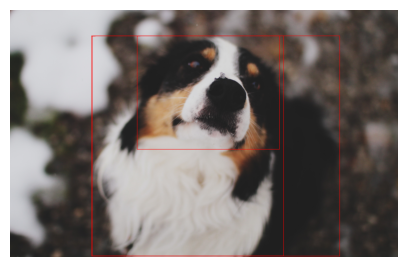

In [11]:
detect_and_draw("/content/mammals/dog/00000007.jpg", ['dog.'])

Отстой, зачем-то сетка обвела еще и голову в отдельный бокс. Попробуем обратиться к псу с большим уважением.

In [12]:
detect_and_draw("/content/mammals/dog/00000007.jpg", ['Mr Dog.'])

meme1.jpg

Давайте еще проверим, что насчет волков на этой картинке.

In [13]:
detect_and_draw("/content/mammals/dog/00000007.jpg", ['Mr Wolf.'])

Хорошо хоть кошки ни одной...

In [14]:
detect_and_draw("/content/mammals/dog/00000007.jpg", ['Big Bad Cat.'])

В целом, при желании Дино тут найдет вам кого угодно. Однако, чтобы не совсем вас разочаровать, замечу, что если вытащить конфиденс (уверенность) сетки в детекции, в наличии собаки на картинке она будет уверена больше.

#### Задание 1 (1 балл)
А не обманывает ли вас преподаватель? Перепишите функцию detect_and_draw (или напишите новую), чтобы она возвращала еще и конфиденс для детекции, и убедитесь, что в наличии собаки на картинке сетка уверена больше. Также выберите любую картинку с волком и проверьте то же самое на ней.

In [15]:
def detect_and_draw_with_confidence(image_path, text, size_text  = 70):
    image = Image.open(image_path).convert("RGB")

    inputs = processor(images=image, text=text, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        box_threshold=0.2,
        text_threshold=0.3,
        target_sizes=[image.size[::-1]]
    )

    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default(size=size_text) # size = size_text to make the confidences more visual
    detection_confidences = []  # list of confidences for each detection

    for result in results:
        boxes = result['boxes'].cpu().numpy()  # Convert to numpy array
        scores = result['scores'].cpu().numpy()
        labels = result['labels']

        for box, score, label in zip(boxes, scores, labels):
            if label:
                box = [int(b) for b in box]
                draw.rectangle(box, outline="magenta", width=5) # I prefer magenta for color :)
                draw.text((box[0], box[1]), f"{label}: {score:.2f}", fill="magenta", font=font)

                detection_confidences.append({'label': label, 'confidence': score, 'box': box}) # Add detection_confidences to list with label and box

    # Display the image with bounding boxes
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    return detection_confidences


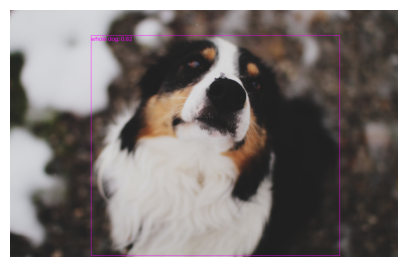

[{'label': 'whole dog', 'confidence': 0.820959, 'box': [988, 320, 4026, 3008]}]

In [16]:
detect_and_draw_with_confidence("/content/mammals/dog/00000007.jpg", ['whole Dog.']) # whole is better

In [17]:
detect_and_draw_with_confidence("/content/mammals/dog/00000007.jpg", ['whole wolf.']) # wolf with 0.65 < 0.82 for dog

[{'label': 'whole wolf',
  'confidence': 0.6538532,
  'box': [987, 318, 4027, 3005]}]

In [18]:
detect_and_draw_with_confidence("/content/mammals/dog/00000007.jpg", ['whole LitEnergy.']) # LitEnergy with 0.44 < 0.63 for dog. Unlucky, sry)

[{'label': 'whole litenergy',
  'confidence': 0.4280752,
  'box': [1026, 318, 3307, 2996]}]

In [19]:
detect_and_draw_with_confidence("/content/mammals/wolf/00000000.jpg", ['mr dog.']) # kaif 0.95 for whole dog)

[{'label': 'mr dog', 'confidence': 0.8475739, 'box': [166, 71, 721, 805]}]

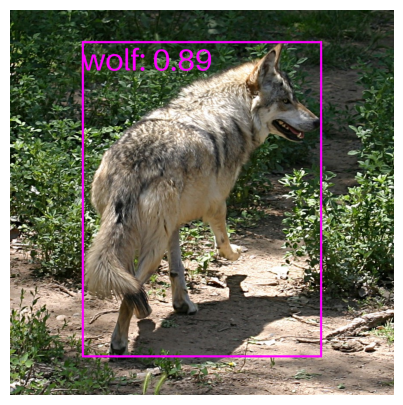

[{'label': 'wolf', 'confidence': 0.89304465, 'box': [166, 72, 721, 804]}]

In [20]:
detect_and_draw_with_confidence("/content/mammals/wolf/00000000.jpg", ['wolf.']) # it is more dog than wolf(

#### Продолжаем, теперь нам нужно сделать датасет для будущей нейросети, то есть в YOLO-формате. Ознакомиться с тем, как должен выглядеть итоговый датасет, можно [здесь](https://docs.ultralytics.com/datasets/detect/).

In [21]:
# чтобы не вылезла какая-то нелепая багуля
import locale
locale.getpreferredencoding = lambda: "UTF-8"

Обращаться к собакам "мистер", конечно, очень весело, но из моих попыток наиболее стабильные результаты DINO выдавал, если просить его выделить "целого пса" или "целого волка".

In [22]:
# заведем словарь отображения промтов в номера классов
LABEL_DICT = {
    'whole dogs': 0,
    'whole wolves': 1,
}

In [23]:
def save_images_as_yolo_dataset(processor, image_dir, dataset_dir, text, label_dict, prefix=''):
    """
    Прогоняем с помощью processor изображения из image_dir со списком возможных промтов text,
    после чего сохраняем их в dataset_dir, при необходимости дописывая prefix
    к имени и метке каждого изображения
    label_dict содержит отображение возможных промтов в метки классов
    """
    os.makedirs(os.path.join(dataset_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'labels'), exist_ok=True)
    for file in os.listdir(image_dir):

        #image = Image.open(os.path.join(IMAGE_DIR, file)).convert("RGB")
        im_cv = cv2.imread(os.path.join(image_dir, file))
        image = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) # openCV читает изображения в BGR
        height, width, channels = image.shape

        inputs = processor(images=image, text=text, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)

        results = processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.2,
            text_threshold=0.3,
            target_sizes=[(height, width)]
        )
        result = results[0] # у нас размер батча 1
        # если хоть что-то распознали
        if result['labels']:
            # скопируем картинку в папку датасета
            shutil.copy2(os.path.join(image_dir, file), os.path.join(dataset_dir, "images", prefix + file))
            # вытащим имя картинки
            name, _ = os.path.splitext(file)
            with open(os.path.join(dataset_dir, "labels", prefix + name + '.txt'), 'w') as labelfile:
                for i in range(len(result['labels'])):
                    if result['labels'][i] in LABEL_DICT:
                        class_id = LABEL_DICT[result['labels'][i]]
                        # конвертируе|м box в yolo формат
                        bbox = xyxy2xywh(result['boxes'][i])
                        labelfile.write(f'{class_id} {bbox[0]/width} {bbox[1]/height} {bbox[2]/width} {bbox[3]/height}\n')
        else:
            print("No labels on image {}".format(file))



Теперь прогоним DINO по всем картинкам, которые я собрал за полчаса на коленке, найдя один датасет на кагле и покачав немного картинки из гугла:

In [24]:
IMAGE_DIR = "/content/mammals/dog/"
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = ["whole dogs."]

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='dog')

In [25]:
IMAGE_DIR = "/content/mammals/wolf/"
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = ["whole wolves."]

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='wolf')

In [26]:
IMAGE_DIR = "/content/wolves_and_dogs/dogs"
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = ["whole dogs."]

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='dog')

IMAGE_DIR = "/content/wolves_and_dogs/wolves"
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = ["whole wolves."]

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='wolf')

IMAGE_DIR = "/content/wolves_and_dogs/pairs"
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = ["whole dogs. whole wolves."]

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='pair')

Теперь нужно отсмотреть датасет, а то мало ли чего там эта сетка высмотрела. Писать визуализацию самому мне было лень, поэтому я обратился к бро GPT. Это я называю *разумным* использованием ChatGPT. Тех, кто тупо кидает всю домашку в промт - ОСУЖДАЕМ!!!111

Перекладывать на железку скучные монотонные задачи (написать визуализацию, разметить выборку) - хорошо.

Перекладывать на железку свой мыслительный процесс - плохо.

In [28]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

class YOLODatasetViewer:
    def __init__(self, dataset_path, batch_size=10):
        """
        Инициализация для последовательного просмотра YOLO-датасета.

        :param dataset_path: Путь к каталогу с датасетом (должен содержать папки images и labels).
        :param batch_size: Количество изображений на одной "странице" (по умолчанию 10).
        """
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.images_dir = os.path.join(dataset_path, 'images')
        self.labels_dir = os.path.join(dataset_path, 'labels')

        # Получаем все изображения в папке
        self.image_files = sorted([f for f in os.listdir(self.images_dir) if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')])
        self.total_images = len(self.image_files)
        self.current_index = 0

    def display_batch(self):
        """
        Отображает следующий пакет изображений с метками.
        """
        # Проверяем, есть ли еще изображения для отображения
        if self.current_index >= self.total_images:
            print("Вы просмотрели все изображения.")
            return

        # Определяем количество изображений в текущем пакете
        num_images = min(self.batch_size, self.total_images - self.current_index)

        # Создаем фигуру для отображения
        fig, axes = plt.subplots(2, 5, figsize=(15, 8))
        axes = axes.flatten()

        # Отображаем текущий пакет изображений
        for i in range(num_images):
            image_path = os.path.join(self.images_dir, self.image_files[self.current_index + i])
            label_path = os.path.join(self.labels_dir, self.image_files[self.current_index + i].replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))

            # Читаем изображение
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Преобразуем в RGB для правильного отображения

            # Проверка наличия файла с метками
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    labels = f.readlines()

                for label in labels:
                    # Парсим данные (class_id x_center y_center width height)
                    parts = label.strip().split()
                    class_id, x_center, y_center, width, height = map(float, parts)

                    # Преобразуем координаты YOLO в пиксели
                    img_height, img_width, _ = image.shape
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height

                    # Рассчитываем координаты прямоугольника
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)


                    # Отображаем прямоугольник
                    image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Красный прямоугольник

            # Отображаем картинку на subplot
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f"Image {image_path.split('/')[-1]}")

        # Показываем все изображения
        plt.tight_layout()
        plt.show()

        # Обновляем индекс для следующего пакета
        self.current_index += num_images

    def reset(self):
        """
        Сбрасывает просмотр на первое изображение.
        """
        self.current_index = 0

# Пример использования:
# dataset_path = '/path/to/your/yolo/dataset'
# viewer = YOLODatasetViewer(dataset_path)
# viewer.display_batch()  # Покажет первые 10 изображений


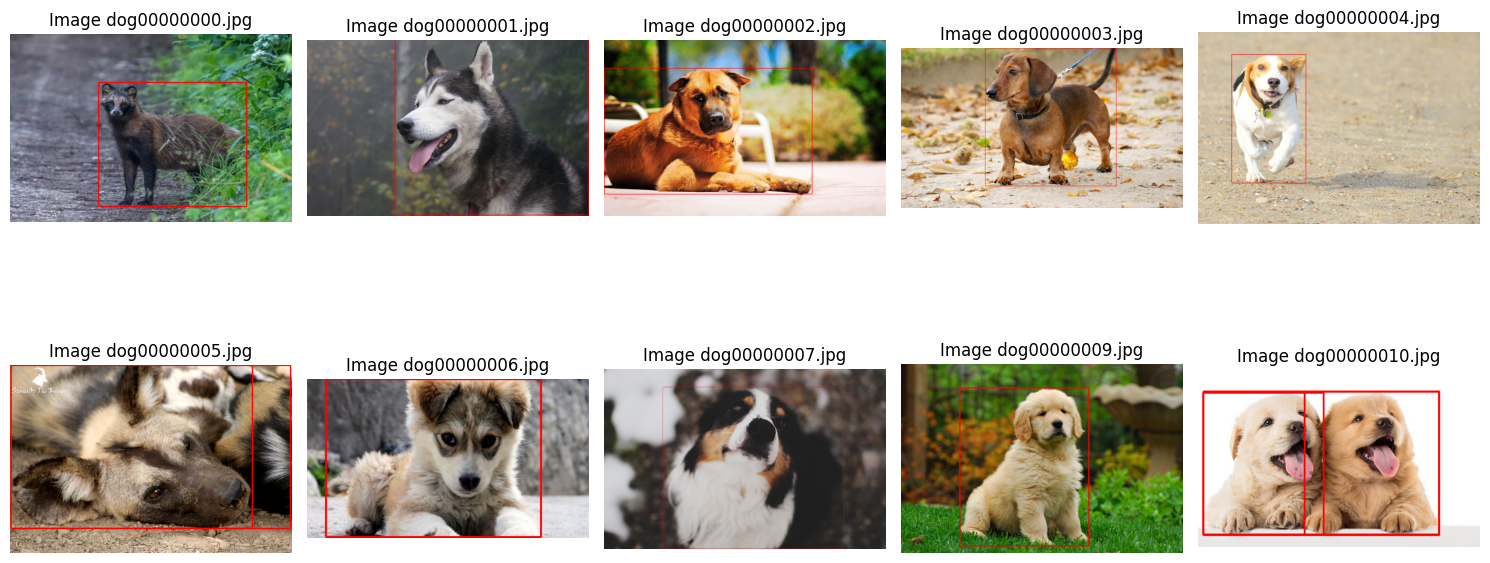

In [29]:
dataset_path = '/content/wolves_and_dogs_dataset'
viewer = YOLODatasetViewer(dataset_path)
viewer.display_batch()

Не пришлось далеко листать, как обнаружилось, что Королевские аналитические логисты на этот раз напихали мне в датасет "cобак" каких-то лемуров, белок, медведей и кучу другого зверья. Придется реально внимательно смотреть.

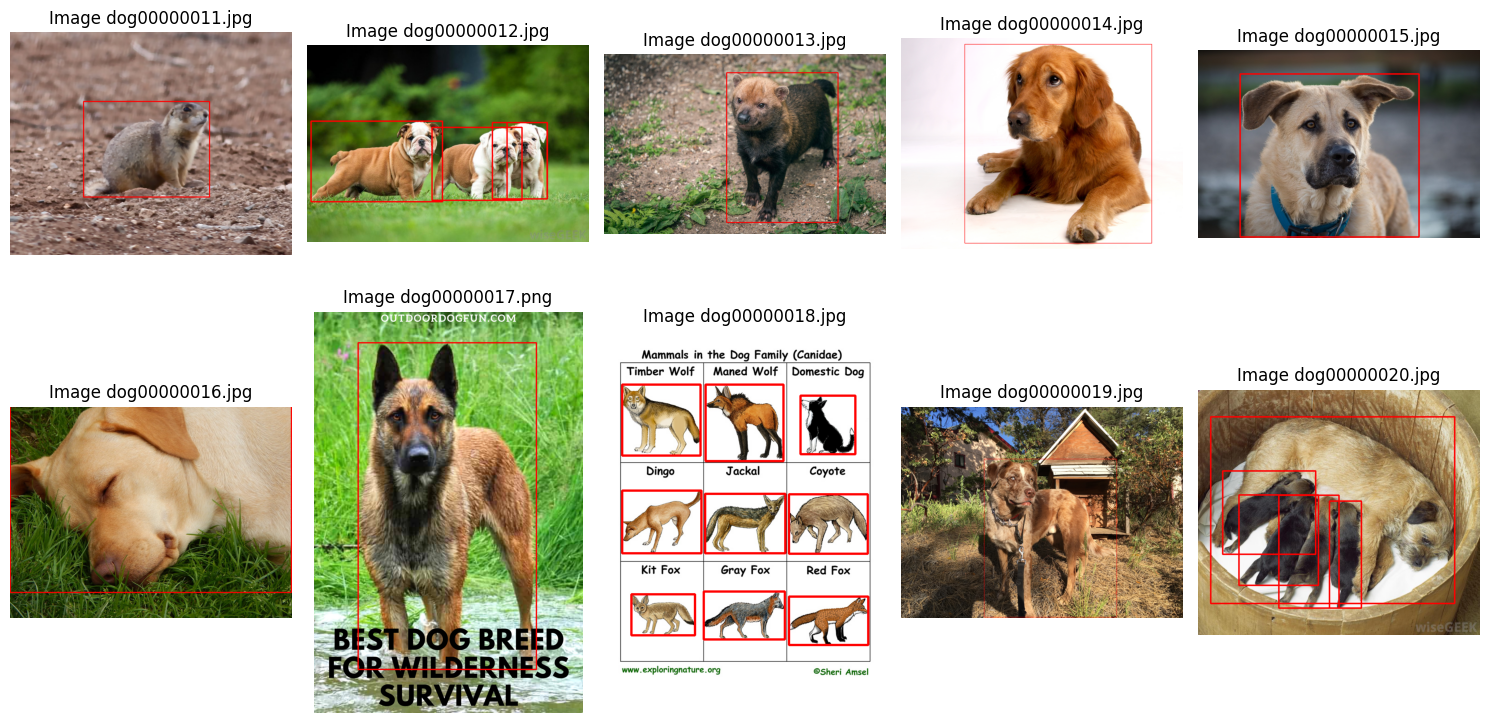

In [30]:
viewer.display_batch()

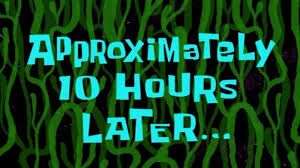

Я отсмотрел все картинки и нашел много ошибок (но хороших было больше, и вообще в основном там просто другие животные, виновата не сетка
). Придется удалить их.

In [49]:
bad_images = ['dog00000000.jpg','dog00000011.jpg', 'dog00000013.jpg', 'dog00000023.jpg', 'dog00000025.jpg',
              'dog00000027.jpg', 'dog00000030.jpg', 'dog00000031.jpg', 'dog00000040.jpg', 'dog00000056.jpg',
              'dog00000058.jpg', 'dog00000064.jpg', 'dog00000078.jpg', 'dog00000085.jpg', 'dog00000091.jpg',
              'dog00000097.jpg', 'wolf00000010.jpg', 'wolf00000029.jpg', 'wolf00000038.jpg', 'wolf00000062.jpg',
              'wolf00000071.jpg', 'wolf00000075.jpg', 'wolf00000077.jpg', 'wolf00000085.jpg', 'dog2dogs1.jpg', 'dog2dogs1.jpeg',
              'dog5dogs1.jpeg', 'dog11dogs1.jpeg',
              'dog2dogs2.jpeg', 'dog2dogs3.jpeg','dog3dogs1.jpeg', 'dog3dogs2.jpeg', 'dog4dogs1.jpeg', 'pairpair1.jpeg',
              'pairpair2.jpeg', 'pairpair3.jpeg', 'wolf2wolfs1.jpeg', 'wolf3wolfs1.jpeg', 'wolf3wolfs2.jpeg',
              'wolf3wolfs3.jpeg', 'wolf3g', 'wolf2wolfs2.jpeg', 'wolf2wolfs3.jpeg',
              'wolf2wolfs4.jpeg', 'wolf2wolfs5.jpeg', 'wowolfs4.jpeg', 'wolf3wolfs5.jpeg',
              'wolf4wolfs1.jpeg', 'wolf4wolfs2.jpeg', 'wolf4wolfs3.jpeg',
              'wolf5wolfs1.jpeg', 'wolf5wolfs2.jpeg', 'wolf5wolfs3.jpeg','wolf7wolfs1.jpeg']

#### Задание 2 (1 балл)
Так много картинок в помойку, жаль! По названиям видно, что сетка довольно плохо справилась с изображениями, где больше одного животного. Попробуйте подобрать к ним более эффективные промты и оставьте их в датасете.   

In [115]:
### Ваш код здесь
### (×_×)
import os
import re

def find_specific_files(files_list):
    """
    Находит пути файлов, где:
    - 'dog' повторяется 2 или более раз,
    - 'wolf' повторяется 2 или более раз,
    - есть слово 'pair'.

    :param files_list: Список выкинутых файолов
    :return: Список путей подходящих файлов.
    """
    root = '/content/wolves_and_dogs_dataset/images'
    # Регулярные выражения для проверки условий
    dog_pattern = re.compile(r'(dog.*?){2,}', re.IGNORECASE)  # 'dog' повторяется 2 или более раз
    wolf_pattern = re.compile(r'(wolf.*?){2,}', re.IGNORECASE)  # 'wolf' повторяется 2 или более раз
    pair_pattern = re.compile(r'pair', re.IGNORECASE)  # слово 'pair'

    matching_files_dogs = []
    matching_files_wolves = []
    matching_files_pairs = []
    other_files = []
    # Обходим все файлы в указанной директории
    for file in files_list:
        if dog_pattern.search(file):
            matching_files_dogs.append(os.path.join(root, file)) # Создаем список собак
        elif wolf_pattern.search(file):
              matching_files_wolves.append(os.path.join(root, file)) # Создаем список волков
        elif pair_pattern.search(file):
              matching_files_pairs.append(os.path.join(root, file)) # Создаем список паp
        else:
             other_files.append(file) # остальные файлы
    return matching_files_dogs, matching_files_wolves, matching_files_pairs, other_files

In [116]:
# Поскольку мы уже все в одну кучу собрали можем искать там
matching_files_dogs, matching_files_wolves, matching_files_pairs, other_files = find_specific_files(bad_images) # Находим все файлы, где предполагаемо больше одного животного

In [117]:
matching_files_dogs

['/content/wolves_and_dogs_dataset/images/dog2dogs1.jpg',
 '/content/wolves_and_dogs_dataset/images/dog2dogs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog5dogs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog11dogs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog2dogs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog2dogs3.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog3dogs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog3dogs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/dog4dogs1.jpeg']

In [52]:
matching_files_wolves

['/content/wolves_and_dogs_dataset/images/wolf2wolfs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf3wolfs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf3wolfs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf3wolfs3.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf2wolfs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf2wolfs3.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf2wolfs4.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf2wolfs5.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf3wolfs5.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf4wolfs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf4wolfs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf4wolfs3.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf5wolfs1.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf5wolfs2.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf5wolfs3.jpeg',
 '/content/wolves_and_dogs_dataset/images/wolf7wolfs1.jpeg']

In [53]:
matching_files_pairs

['/content/wolves_and_dogs_dataset/images/pairpair1.jpeg',
 '/content/wolves_and_dogs_dataset/images/pairpair2.jpeg',
 '/content/wolves_and_dogs_dataset/images/pairpair3.jpeg']

Путем моих поисков наилуший результат показал промт

**Dog:** Detect individual dogs, focusing on each dog.

**Wolf:** Detect individual wolves, focusing on each wolf.

**Pair:** Select dogs individually. Select wolves individually.

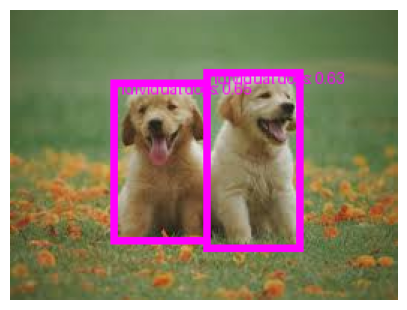

[{'label': 'individual dogs',
  'confidence': 0.62791896,
  'box': [129, 40, 195, 161]},
 {'label': 'individual dogs',
  'confidence': 0.6461059,
  'box': [67, 47, 133, 156]}]

In [54]:
detect_and_draw_with_confidence(matching_files_dogs[0], ["Detect individual dogs, focusing on each dog."], size_text=10)

In [87]:
detect_and_draw_with_confidence(matching_files_wolves[2], ["Detect individual wolves, focusing on each wolf."], size_text=10)

[{'label': 'individual wolves',
  'confidence': 0.527857,
  'box': [71, 7, 198, 166]},
 {'label': 'individual wolves',
  'confidence': 0.50059134,
  'box': [185, 50, 270, 151]},
 {'label': 'individual wolves',
  'confidence': 0.46791568,
  'box': [6, 51, 71, 151]}]

In [112]:
detect_and_draw_with_confidence(matching_files_pairs[2], ["Select dogs individually. Select wolves individually."], size_text=10)

[{'label': 'select dogs', 'confidence': 0.46203238, 'box': [88, 0, 222, 219]},
 {'label': 'select wolves',
  'confidence': 0.4531647,
  'box': [11, 68, 147, 221]}]

In [113]:
# Немного переделаем нашу функцию, чтобы обработать наши новые промты
dog_promt = ["Detect individual dogs, focusing on each dog."]
wolf_promt = ["Detect individual wolves, focusing on each wolf."]
pair_promt = ["Select dogs individually. Select wolves individually."]

In [114]:
def copy_files_to_folder(file_paths, destination_folder):
    """
    Копирует файлы из списка путей в указанную папку назначения, сохраняя имена файлов.

    :param file_paths: список путей к файлам
    :param destination_folder: путь к папке, куда копировать файлы
    """
    os.makedirs(destination_folder, exist_ok=True)  # Создаём папку, если её нет
    for file_path in file_paths:
        if os.path.exists(file_path):
            # Копируем файл, сохраняя имя
            shutil.copy2(file_path, destination_folder)
        else:
            print(f"File not found: {file_path}")

destination_folder_dogs = "/content/my_wolves_and_dogs/dogs"
destination_folder_wolves = "/content/my_wolves_and_dogs/wolves"
destination_folder_pairs = "/content/my_wolves_and_dogs/pairs"

copy_files_to_folder(matching_files_wolves, destination_folder_wolves)
copy_files_to_folder(matching_files_dogs, destination_folder_dogs)
copy_files_to_folder(matching_files_pairs, destination_folder_pairs)
print("Файлы успешно скопированы!")


File not found: /content/wolves_and_dogs_dataset/images/dog5dogs1.jpeg
Файлы успешно скопированы!


In [119]:
other_files.append('dog5dogs1.jpeg') # Добавим файл, который не удалось найти

In [121]:
# Удалим, наши плохие файлы и метки
for file in  other_files:
    try:
        name, _ = os.path.splitext(file)
        os.remove(os.path.join(DATASET_DIR, 'images', file))
        os.remove(os.path.join(DATASET_DIR, 'labels', name + '.txt'))
    except FileNotFoundError:
        continue

In [122]:
IMAGE_DIR = destination_folder_dogs
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = dog_promt

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='dog')

IMAGE_DIR = destination_folder_wolves
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = wolf_promt

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='wolf')

IMAGE_DIR = destination_folder_pairs
DATASET_DIR = "/content/wolves_and_dogs_dataset/"
text = pair_promt

save_images_as_yolo_dataset(processor=processor, image_dir=IMAGE_DIR,
                            dataset_dir=DATASET_DIR, text=text, label_dict=LABEL_DICT, prefix='pair')

В датасете YOLO еще обязательно должен быть yaml файл с классами и путями.

In [123]:
!cp /content/hw_week7/dataset.yaml /content/wolves_and_dogs_dataset/

Засплитим наши данные на трейн, валидацию и тест. Валидация в нашем случае нужна для того, чтобы yolo могла проверить себя и убедиться, что лосс падает не только на обучающей выборке.

In [124]:
import random

def split_yolo_dataset(dataset_path, val_size = 0.15, test_size = 0.15):
    os.makedirs(os.path.join(dataset_path, 'images', 'train'), exist_ok = True)
    os.makedirs(os.path.join(dataset_path, 'images', 'val'), exist_ok = True)
    os.makedirs(os.path.join(dataset_path, 'images', 'test'), exist_ok = True)
    os.makedirs(os.path.join(dataset_path, 'labels', 'train'), exist_ok = True)
    os.makedirs(os.path.join(dataset_path, 'labels', 'val'), exist_ok = True)
    os.makedirs(os.path.join(dataset_path, 'labels', 'test'), exist_ok = True)
    files = [file for file in os.listdir(os.path.join(dataset_path, 'images')) if os.path.isfile(os.path.join(dataset_path, 'images', file))]
    for file in files:
        name, _ = os.path.splitext(file)
        roll = random.random()
        if roll < val_size:
            shutil.move(os.path.join(dataset_path, 'images', file), os.path.join(dataset_path, 'images', 'val'))
            shutil.move(os.path.join(dataset_path, 'labels', name + '.txt'), os.path.join(dataset_path, 'labels', 'val'))
        elif roll < val_size + test_size:
            shutil.move(os.path.join(dataset_path, 'images', file), os.path.join(dataset_path, 'images', 'test'))
            shutil.move(os.path.join(dataset_path, 'labels', name + '.txt'), os.path.join(dataset_path, 'labels', 'test'))
        else:
            shutil.move(os.path.join(dataset_path, 'images', file), os.path.join(dataset_path, 'images', 'train'))
            shutil.move(os.path.join(dataset_path, 'labels', name + '.txt'), os.path.join(dataset_path, 'labels', 'train'))


In [149]:
cd ..

/content


In [150]:
split_yolo_dataset(DATASET_DIR)

Error: Destination path '/content/wolves_and_dogs_dataset/labels/train/dog2dogs1.txt' already exists

Загрузим самую маленькую модель семейства YOLO, nano. Поскольку у нас мало данных и простая задача, она кажется оптимальным выбором.

In [151]:
yolo_model = YOLO("yolo11m.pt")

100%|██████████| 38.8M/38.8M [00:00<00:00, 222MB/s]


Запустим обучение на дефолтных параметрах, patience отвечает за раннюю остановку: если 10 эпох лосс на валидации не падает, обучение остановится. 100 эпох на таком маленьком датасете в любом случае пролетят быстро.

In [152]:
yolo_model.train(data='/content/wolves_and_dogs_dataset/dataset.yaml',
                 device=device,
                 plots=True,
                 epochs=100,
                 patience=10,
                 batch=16)

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/wolves_and_dogs_dataset/dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning /content/wolves_and_dogs_dataset/labels/train... 156 images, 20 backgrounds, 1 corrupt: 100%|██████████| 157/157 [00:00<00:00, 439.87it/s]

train: WARNING ⚠️ /content/wolves_and_dogs_dataset/images/train/dog00000092.jpg: ignoring corrupt image/label: image file is truncated (62 bytes not processed)
train: New cache created: /content/wolves_and_dogs_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/wolves_and_dogs_dataset/labels/val... 44 images, 5 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 260.96it/s]

val: New cache created: /content/wolves_and_dogs_dataset/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      8.84G     0.7691      2.562       1.36         39        640: 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         44         62       0.37      0.462      0.347      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       8.7G     0.9592      1.825       1.45         35        640: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         44         62      0.342      0.254      0.234     0.0939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      8.78G     0.9971       1.66      1.454         37        640: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         44         62      0.411      0.425      0.252     0.0993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.74G      1.097      1.676      1.515         36        640: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         44         62     0.0159      0.281     0.0103    0.00507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      8.73G      1.254      1.681      1.573         41        640: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         44         62     0.0156     0.0286    0.00125   0.000268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.74G      1.365      1.796      1.692         55        640: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         44         62     0.0028     0.0286   0.000644    0.00015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       8.7G      1.371      1.754      1.714         37        640: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         44         62      0.134     0.0899     0.0329     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      8.75G        1.4      1.885       1.68         63        640: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         44         62     0.0402     0.0143    0.00194   0.000263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      8.79G       1.38       1.82      1.701         24        640: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         44         62   4.97e-05     0.0185   2.48e-05    9.9e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      8.73G      1.345      1.782       1.69         39        640: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         44         62     0.0113     0.0143    0.00315    0.00134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       8.7G      1.441      1.765      1.742         38        640: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         44         62     0.0399      0.119     0.0159    0.00426
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



11 epochs completed in 0.040 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 40.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


                   all         44         62      0.375      0.462      0.348      0.183
                   dog         19         35      0.279      0.221      0.131     0.0758
                  wolf         20         27      0.472      0.704      0.565      0.289
Speed: 0.3ms preprocess, 11.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7afcf02fdba0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Сохраним модельку.

In [153]:
yolo_model.save("wolf-dog.pt")

А теперь проверяем!

In [154]:
# Загружаем модель из файла
model = YOLO("wolf-dog.pt")

In [165]:

results = model.predict("/content/wolves_and_dogs_dataset/images/test/dog00000033.jpg")
results[0].show()


image 1/1 /content/wolves_and_dogs_dataset/images/test/dog00000033.jpg: 384x640 1 dog, 1 wolf, 166.1ms
Speed: 4.6ms preprocess, 166.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


In [161]:
results = yolo_model.predict("/content/hw_week7/wolf.jpeg")
results[0].show()


image 1/1 /content/hw_week7/wolf.jpeg: 608x640 1 dog, 1 wolf, 73.4ms
Speed: 2.9ms preprocess, 73.4ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


Ну все, волк теперь доволен! Давайте для контроля теперь глянем на метрики на тесте. Подробнее о метриках для детекции [здесь](https://docs.ultralytics.com/guides/yolo-performance-metrics/).

In [166]:
metrics = yolo_model.val(data='/content/wolves_and_dogs_dataset/dataset.yaml', split="test", device=device, )

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/wolves_and_dogs_dataset/labels/test... 33 images, 2 backgrounds, 0 corrupt: 100%|██████████| 33/33 [00:00<00:00, 493.13it/s]

val: New cache created: /content/wolves_and_dogs_dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


                   all         33         48      0.364      0.521      0.346      0.214
                   dog         16         24      0.314      0.458      0.207      0.144
                  wolf         15         24      0.415      0.583      0.484      0.284
Speed: 0.3ms preprocess, 36.1ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/train32


Поскольку наш датасет очень маленький, вопрос с аугментациями в нем стоит еще острее, чем обычно. В YOLO много своих аугментаций, особый упор они делают на сложные Mosaic и Mixup аугментации, которые смешивают изображения. А вот настраивать некоторые простые свои может оказаться затруднительно. Однако, через костыльный [манки-патчинг](https://en.wikipedia.org/wiki/Monkey_patch#:~:text=In%20computer%20programming%2C%20monkey%20patching,altering%20the%20original%20source%20code.) можно вставить в YOLO блок простых и понятных аугментаций из библиотеки Albumentations, список всех возможных [прилагается](https://albumentations.ai/docs/getting_started/transforms_and_targets/).

In [ ]:
from ultralytics.data.augment import Albumentations
from ultralytics.utils import LOGGER, colorstr

def __init__(self, p=1.0):
        """Initialize the transform object for YOLO bbox formatted params."""
        self.p = p
        self.transform = None
        prefix = colorstr("albumentations: ")
        try:
            import albumentations as A

            spatial_transforms = {
                "Affine",
                "BBoxSafeRandomCrop",
                "CenterCrop",
                "CoarseDropout",
                "Crop",
                "CropAndPad",
                "CropNonEmptyMaskIfExists",
                "D4",
                "ElasticTransform",
                "Flip",
                "GridDistortion",
                "GridDropout",
                "HorizontalFlip",
                "Lambda",
                "LongestMaxSize",
                "MaskDropout",
                "MixUp",
                "Morphological",
                "NoOp",
                "OpticalDistortion",
                "PadIfNeeded",
                "Perspective",
                "PiecewiseAffine",
                "PixelDropout",
                "RandomCrop",
                "RandomCropFromBorders",
                "RandomGridShuffle",
                "RandomResizedCrop",
                "RandomRotate90",
                "RandomScale",
                "RandomSizedBBoxSafeCrop",
                "RandomSizedCrop",
                "Resize",
                "Rotate",
                "SafeRotate",
                "ShiftScaleRotate",
                "SmallestMaxSize",
                "Transpose",
                "VerticalFlip",
                "XYMasking",
            }

            # Insert required transformation here

        # Список аугментаций
            T = [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.RandomGamma(gamma_limit=(80, 120), p=0.4),
                A.MotionBlur(blur_limit=3, p=0.2),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.Perspective(scale=(0.05, 0.1), p=0.3),
                A.RandomSizedBBoxSafeCrop(height=512, width=512, p=0.4),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
                A.Resize(height=640, width=640, p=1.0),
            ]
            self.contains_spatial = any(transform.__class__.__name__ in spatial_transforms for transform in T)
            self.transform = (
                A.Compose(T, bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))
                if self.contains_spatial
                else A.Compose(T)
            )

            LOGGER.info(prefix + ", ".join(f"{x}".replace("always_apply=False, ", "") for x in T if x.p))
        except ImportError:  # package not installed, skip
            pass
        except Exception as e:
            LOGGER.info(f"{prefix}{e}")

Albumentations.__init__ = __init__

#### Задание 3 (2 балла)
Подберите аугментации для йоло ([родные] или из Albumentations, как удобно), которые улучшат показатели по сравнению с дефолтными либо на этих данных, либо на ваших (смотри далее).

In [ ]:
### Ваш код здесь
### (×_×)

Итак, я написал почти весь код сам, что же будете делать вы?

#### Задание 4 (4 балла)
Выберите 1 из классов, представленных в датасете COCO для детекции, и какой-нибудь другой класс, который не представлен в нем (+балл, если они реально похожи, как волки и собаки). Соберите данные, по аналогии с кодом выше разметьте их, обучите YOLO и продемонстрируйте результат. Модель сохраните и приложите к решению.

#### Задание 5 (2 балла)
Получаете баллы, если я запустил вашу модельку на рандомной картинке из интернета, и она сработала правильно.

#### Задание 5.1 (1 балл)
Напишите о своем любимом месте в Москве. Почему именно оно?

Hyundai MotorStudio, помню в период, когда не было интернета дома друг пригласил вместе посидеть в коворкинге. С тех пор одно из любимых мест.

**Если честно и без приукрас ноутбук какой-то странный, по крайней мере, то что написано расходится с действительностью, поэтому мы напишем свой. Функции отвечающии заданиям я оставлю, не вопрос, но думаю, что все остальное надо переделать.**